<a href="https://colab.research.google.com/github/Nikhil-S15/Music-Generation-LSTM/blob/main/MusicGenertaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!pip install music21
!apt-get install -y lilypond


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35 ghostscript
  libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libptexenc1
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lilypond-data
  lilypond-fonts lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x lilypond-doc
  python3-lxml poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc
The following NEW packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)


In [ ]:
import os

# List the contents of the root directory
print(os.listdir('/content/drive'))

['.file-revisions-by-id', 'MyDrive', '.shortcut-targets-by-id', '.Trash-0']


In [ ]:
print(os.listdir('/content/drive/My Drive'))

['Getting started.pdf', 'pyary (3).pptx', 'Untitled spreadsheet.gsheet', 'IMG_20200803_081218.jpg', 'RegisteredStudentBillReport (2) (1).pdf', 'RegisteredStudentBillReport (2).pdf', 'pyary (2).pptx', 'pyary (1).pptx', 'pyary.pptx', 'seminar.pptx', 'NIKHIL FINAL PPT (10).pptx', 'PQ Assignment.pdf', 'NIKHIL FINAL PPT (9).pptx', 'NIKHIL FINAL PPT (8).pptx', 'NIKHIL FINAL PPT (7).pptx', 'NIKHIL FINAL PPT (6).pptx', 'NIKHIL FINAL PPT (5).pptx', 'NIKHIL FINAL PPT (4).pptx', 'NIKHIL FINAL PPT (3).pptx', 'THE TARIFFS OF TOMORROW (2).pptx', 'THE TARIFFS OF TOMORROW (1).pptx', 'THE TARIFFS OF TOMORROW.pptx', 'EC Assignment 1 (2).pdf', 'EC Assignment 1 (1).pdf', 'EC Assignment 1.pdf', 'LCS mod-5.pdf', 'LCS mod-5.gdoc', 'NIKHIL FINAL PPT (2).pptx', 'NIKHIL FINAL PPT.ppt', 'NIKHIL FINAL PPT (1).pptx', 'NIKHIL FINAL PPT.pptx', 'CamScanner 10-23-2020 12.28.22.pdf', 'CamScanner.pdf', '1-seminar 2 paper.pdf', 'Exp..pdf', '45DBE5B8-646C-4C5B-80C2-811F68F0854B.jpeg', '3A692A26-A03C-46E9-9454-05A3C27B5E6D

In [ ]:
print(os.listdir('/content/drive/My Drive/classical-music-midi'))

['.DS_Store', 'muss', 'brahms', 'mendelssohn', 'borodin', 'schubert', 'debussy', 'granados', 'grieg', 'bach', 'albeniz', 'balakir', 'burgm', 'haydn', 'liszt', 'beeth', 'schumann', 'chopin', 'mozart', 'tschai']


In [ ]:
filepath = "/content/drive/My Drive/classical-music-midi/chopin/"
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath + i
        midi = converter.parse(tr)
        all_midis.append(midi)


In [ ]:
#Helping function
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 57894


In [ ]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['E5', 'F5', 'E5', 'D5', '2.5.9', 'F5', '2.5.9', 'F5', '5.9.0', 'E5', '9.0.4', '2.4', 'D5', 'C#5', 'D5', '2.4.8', 'E-5', 'E5', '2.4.8', 'B4', 'D5', 'A2', 'C5', '0.4', 'A4', 'B4', 'A4', 'G#4', '0.4', 'A4', 'A2', 'B4', 'E5', '4.7.11', 'B2', 'B4', 'G4', 'E4', '7.11', 'B4', 'E-4', '6.11', 'E4', '4.7.11', 'E2', 'E5', 'F5', 'E5', 'D5', '2.5.9']


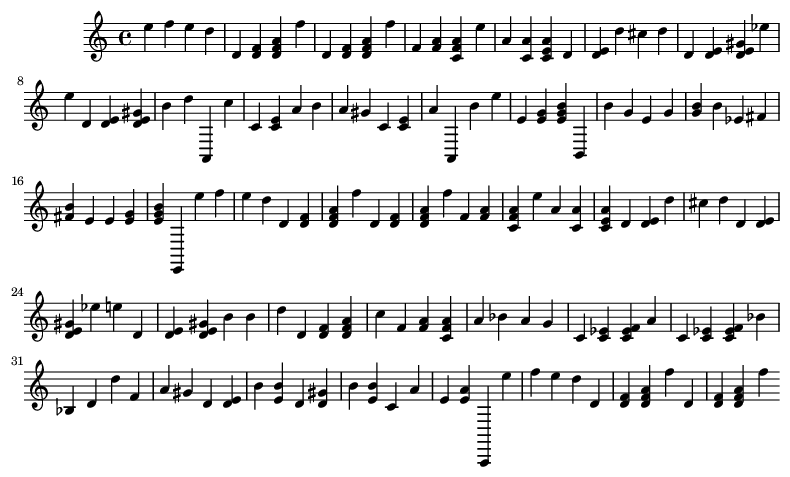

In [ ]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))

def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

In [ ]:
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Notes = list(count_num.keys())
Recurrence = list(count_num.values())

def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Total unique notes in the Corpus: 397
Average recurrence for a note in Corpus: 145.8287153652393
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 time


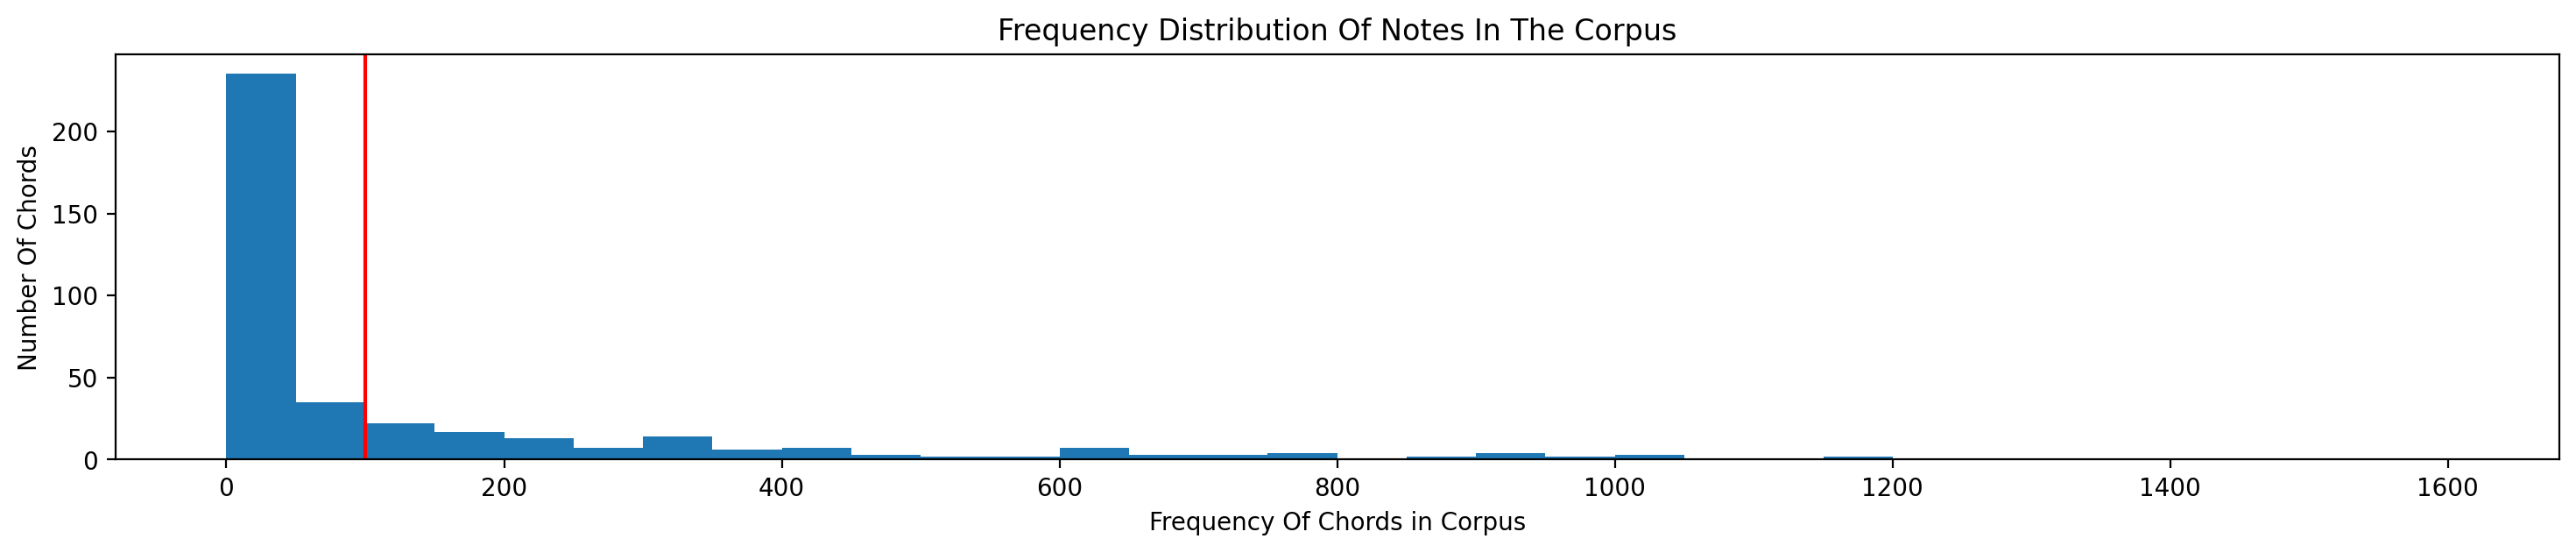

Total number of notes that occur less than 100 times: 270
Length of Corpus after eliminating the rare notes: 53110


In [ ]:


plt.figure(figsize=(18,3))
bins = np.arange(0, (max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins)
plt.axvline(x=100, color="red")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

rare_note = [key for key, value in count_num.items() if value < 100]
print("Total number of notes that occur less than 100 times:", len(rare_note))

Corpus = [element for element in Corpus if element not in rare_note]
print("Length of Corpus after eliminating the rare notes:", len(Corpus))

In [ ]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 270


In [ ]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 53110


In [ ]:
# Storing all the unique characters present in my corpus to bult a mapping dic.
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 53110
Number of unique characters: 127


In [ ]:
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)



Total number of sequences in the Corpus: 53070


In [ ]:
X = np.reshape(features, (L_datapoints, length, 1)) / float(L_symb)
y = tf.keras.utils.to_categorical(targets)




In [ ]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

**MODEL** **BUILDING**

In [ ]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)


In [ ]:
#Model's Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 127)               32639     
                                                                 
Total params: 1938559 (7.40 MB)
Trainable params: 193855

In [ ]:

#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200
166/166 [==============================] - 12s 42ms/step - loss: 4.6654
Epoch 2/200
166/166 [==============================] - 7s 41ms/step - loss: 4.5553
Epoch 3/200
166/166 [==============================] - 7s 41ms/step - loss: 4.4147
Epoch 4/200
166/166 [==============================] - 7s 41ms/step - loss: 4.3874
Epoch 5/200
166/166 [==============================] - 7s 42ms/step - loss: 4.3770
Epoch 6/200
166/166 [==============================] - 7s 42ms/step - loss: 4.3724
Epoch 7/200
166/166 [==============================] - 7s 42ms/step - loss: 4.3565
Epoch 8/200
166/166 [==============================] - 7s 43ms/step - loss: 4.3503
Epoch 9/200
166/166 [==============================] - 7s 43ms/step - loss: 4.3381
Epoch 10/200
166/166 [==============================] - 7s 44ms/step - loss: 4.3154
Epoch 11/200
166/166 [==============================] - 7s 44ms/step - loss: 4.2888
Epoch 12/200
166/166 [==============================] - 7s 44ms/step - loss: 4.2623


[Text(0.5, 0, 'Epochs')]

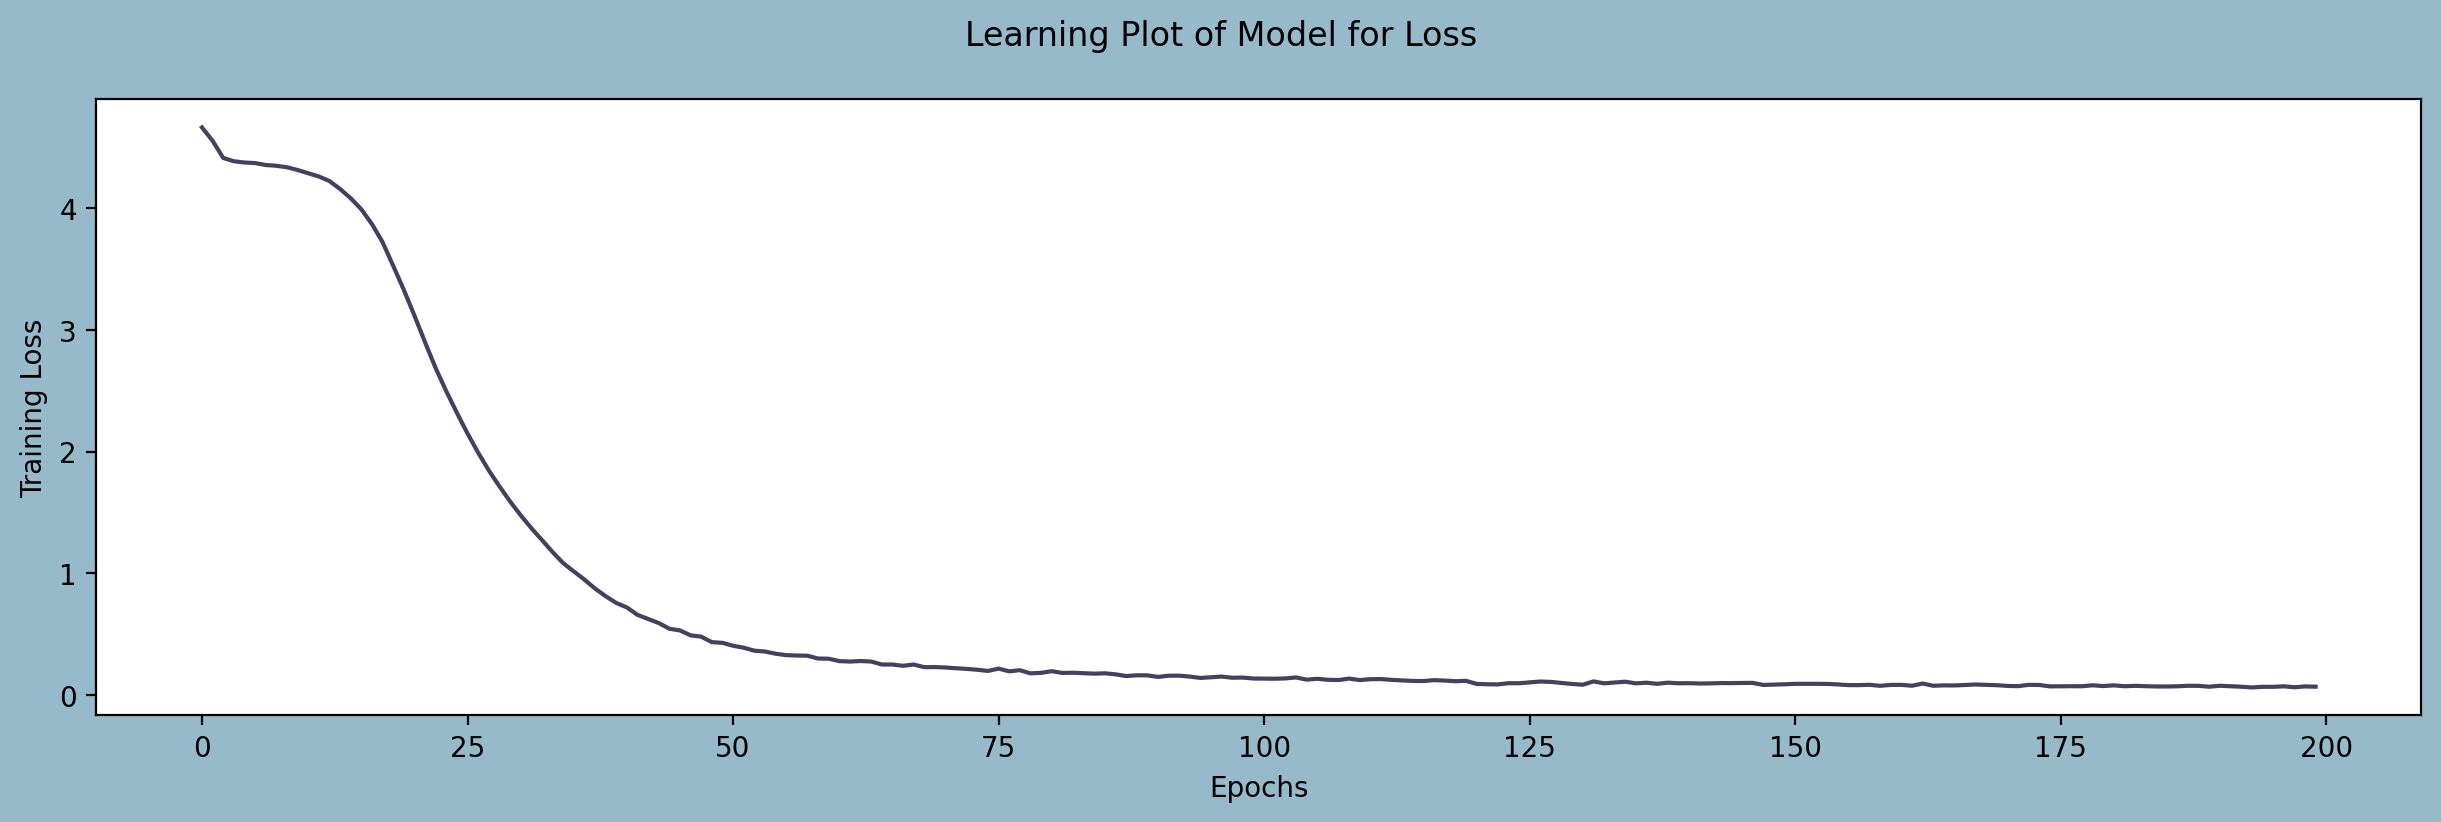

In [ ]:
#Plotting the learnings
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

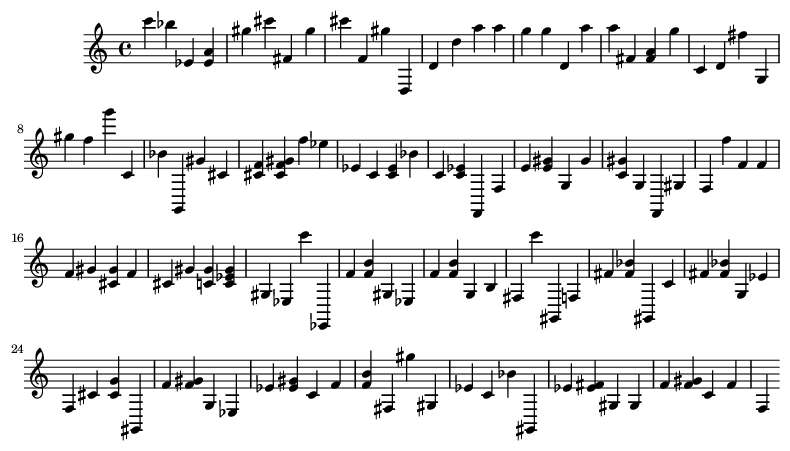

In [ ]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)
show(Melody)

In [ ]:
Melody.write('midi','Melody_Generated.mid')

'Melody_Generated.mid'

In [ ]:
IPython.display.Audio('Melody_Generated.mid')

In [ ]:
from google.colab import files
files.download('/content/Melody_Generated.mid')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>